In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from skopt import BayesSearchCV

In [58]:
df = pd.read_csv("../materials.csv")
selected_features = [
    "band_gap",
    "is_metal",
    "formation_energy_per_atom",
    "efermi",
    "ordering",
    "total_magnetization_normalized_vol",
    "total_magnetization",
    "num_magnetic_sites",
    "density",
    "density_atomic",
]
df = df[selected_features]
df.dropna(inplace=True)
label_encoder = LabelEncoder()
df["ordering"] = label_encoder.fit_transform(df["ordering"])
df["is_metal"] = label_encoder.fit_transform(df["is_metal"])
X = df.drop(columns=["band_gap"])
y = df["band_gap"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [59]:
search_space = {
    'n_estimators': (100, 500),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'lambda': (1.0, 10.0, 'uniform')
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

search = BayesSearchCV(estimator=xgb_reg, search_spaces=search_space, n_iter=10, cv=3, n_jobs=-1, verbose=2, random_state=42)

In [60]:
search.fit(X_train, y_train)
best_params = search.best_params_
print(f"Best parameters: {best_params}")

best_model = search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: OrderedDict([('colsample_bytree', 0.9186941777766422), ('lambda', 8.94983749642776), ('learning_rate', 0.02806554771929606), ('max_depth', 10), ('n_estimators', 446), ('subsample', 0.5311564704220357)])


In [61]:
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)

Mean Squared Error: 0.24492116490470747
Mean Absolute Error: 0.23121081205580193
R² Score: 0.8640868049185949


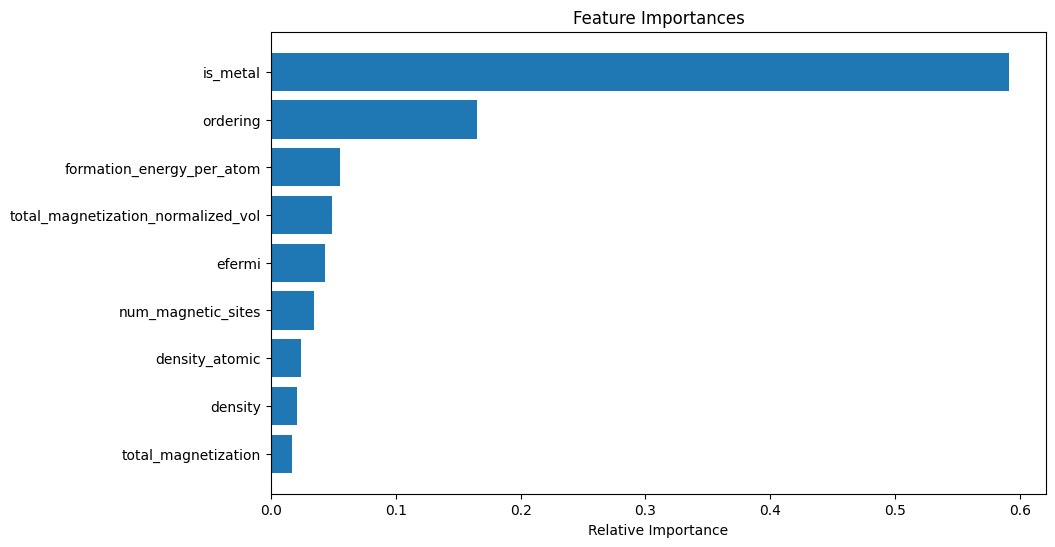

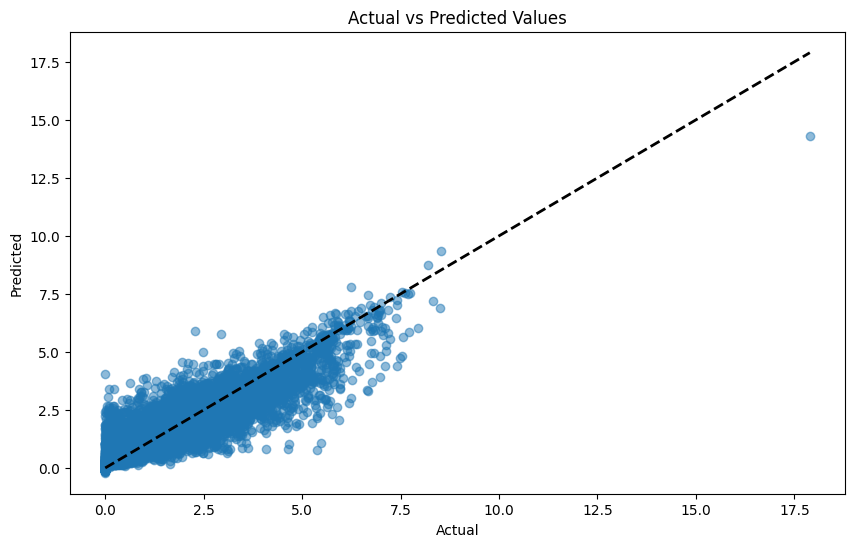

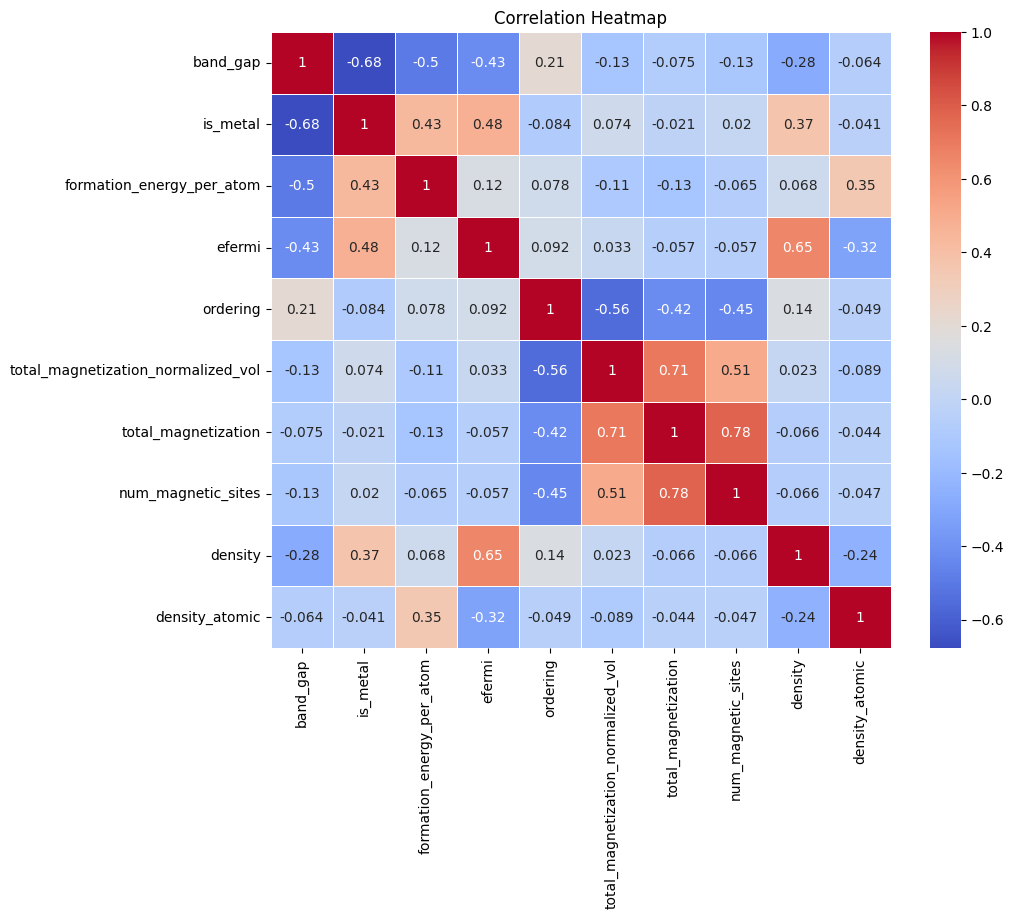

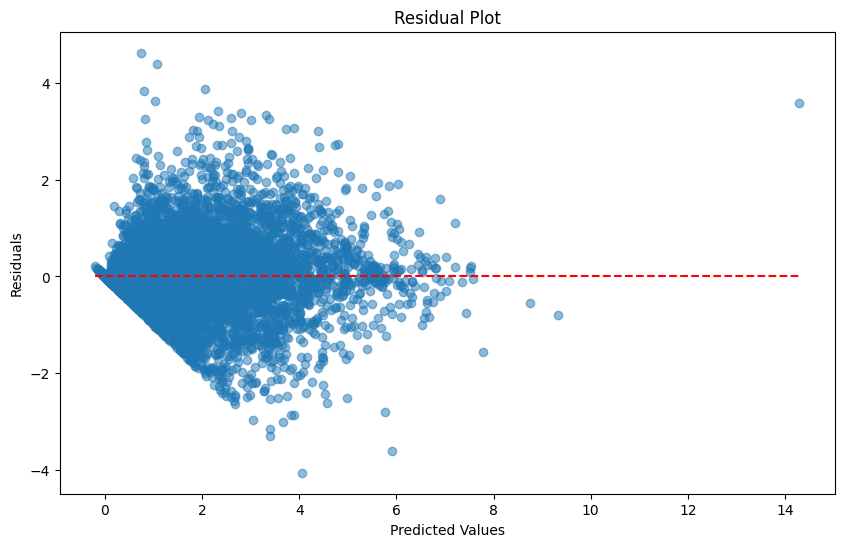

In [62]:
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values")
plt.show()
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(0, min(y_pred), max(y_pred), colors='r', linestyles='dashed')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()
from sklearn.model_selection import learning_curve

In [63]:
train_sizes, train_scores, test_scores = learning_curve(best_model, X_scaled, y, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

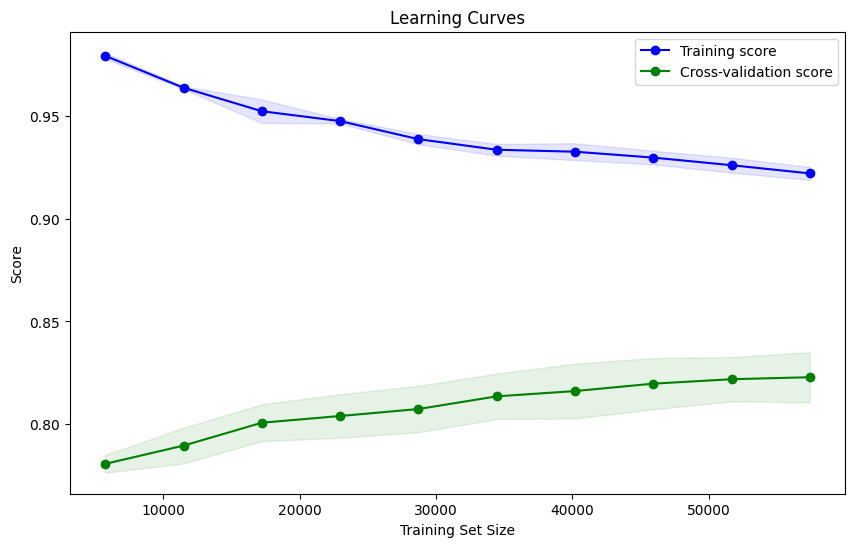

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc='best')
plt.show()